In [2]:
import galsim
import numpy as np
import matplotlib
import pylab
import os

In [3]:
from galsim import RealGalaxy, RealGalaxyCatalog
dir="/Users/maccrann.2/code/GalSim/examples/data"
cosmos_cat = RealGalaxyCatalog(file_name="real_galaxy_catalog_23.5_example.fits", dir=dir)

In [10]:
from matplotlib.patches import Ellipse
from galsim import GalSimHSMError
#The bluey-purpley color used by the default
#beamer color scheme
BEAMER_COLOR=(0.2,0.2,0.7)

hsmparams=galsim.hsm.HSMParams(bound_correct_wt=10)

def add_ellipse(ax, im, color=BEAMER_COLOR):
    """
    Add an hsm measured ellipse to the stamp.
    The try and except here is a hack that seems
    to prevent the fit failing now and then for 
    highly elliptical objects, inspired by this 
    thread https://github.com/GalSim-developers/GalSim/issues/384
    """
    #Do the hsm fit
    try:
        moments = im.FindAdaptiveMom()
    except GalSimHSMError:
        moments = im.FindAdaptiveMom(hsmparams=hsmparams)
    #get shape, size (sigma), and centroid
    g = moments.observed_shape
    sigma = moments.moments_sigma
    centroid = moments.moments_centroid
    #Plot an ellipse
    ellipse = Ellipse((centroid.x-1, centroid.y-1), 
                      2*sigma/g.q**0.5, 2*sigma*g.q**0.5, 
                      angle=g.beta/galsim.degrees, facecolor='none', 
                      edgecolor=color,
                      linewidth=3
                     )
    ax.add_patch(ellipse)


def save_stamps(cosmos_cat, index, outdir, 
                psf_ground=None, psf_space=None, 
                cmap='gray_r', orig_scale=0.01, 
                pix_scale=0.1, n_orig=200, figsize=None, 
                in_a_row=True, add_text=True, blend_index=10, 
                add_hsm_ellipse=False, g1=0.1, g2=0.,
                annotate=True, fontsize=22, spanish=False):
    """
    Save images of stamps with various observational 
    effects applied. 
    """
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        
    n_stamps=5
    if figsize is None:
        if in_a_row:
            figsize = (4*n_stamps,4)
        else:
            figsize = (4,4)
            
    #get the galaxy
    g = RealGalaxy(cosmos_cat, i, flux=1.)
    if psf_ground is None:
        psf_ground = galsim.Gaussian(fwhm=0.5,flux=1.)
    if psf_space is None:
        psf_space = galsim.Gaussian(fwhm=0.2,flux=1.)
    
    g_space_noshear = galsim.Convolve(g,psf_space)
    g = g.shear(g1=g1, g2=g2)
    g_space = galsim.Convolve(g,psf_space)
    g_ground = galsim.Convolve(g,psf_ground)
    

    #Draw g_space, first unsheared
    fig=pylab.figure(figsize=figsize)
    if in_a_row:
        ax=fig.add_subplot(1,n_stamps,1)
    else:
        ax=fig.add_subplot(111)
    im_space=g_space_noshear.drawImage(scale=orig_scale,nx=n_orig,ny=n_orig)
    
    ax.imshow(im_space.array,origin='lower',interpolation='nearest',cmap='gray_r')
    ax.axis('off')
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, "stamp0.jpg"))
    if add_hsm_ellipse:
        add_ellipse(ax, im_space)
    if not in_a_row:
        fig.tight_layout()
        fig.savefig(os.path.join(outdir, "stamp1.jpg"))

    #Draw g_space, now sheared version
    fig=pylab.figure(figsize=figsize)
    if in_a_row:
        ax=fig.add_subplot(1,n_stamps,1)
    else:
        ax=fig.add_subplot(111)
    im_space=g_space.drawImage(scale=orig_scale,nx=n_orig,ny=n_orig)
    
    ax.imshow(im_space.array,origin='lower',interpolation='nearest',cmap='gray_r')
    ax.axis('off')
    
    if annotate:
        if spanish:
            text = "+ 10 x lente"
        else:
            text = "+ 10 x shear"
        ax.text(0.95, 0.95, text,
               color=BEAMER_COLOR, transform=ax.transAxes,
               horizontalalignment='right',
               verticalalignment='top',
               size=fontsize)
    
    if add_hsm_ellipse:
        add_ellipse(ax, im_space)
    if not in_a_row:
        fig.tight_layout()
        fig.savefig(os.path.join(outdir, "stamp2.jpg"))
        
        
    #Draw g_ground
    g_ground = galsim.Convolve(g,psf_ground)
    if in_a_row:
        ax=fig.add_subplot(1,n_stamps,2)
    else:
        fig=pylab.figure(figsize=figsize)
        ax=fig.add_subplot(111)
    im_ground=g_ground.drawImage(scale=orig_scale,nx=n_orig,ny=n_orig)
    ax.imshow(im_ground.array,origin='lower',interpolation='nearest',cmap='gray_r')
    ax.axis('off')
    
    if annotate:
        if spanish:
            text = "+ atmósfera"
        else:
            text = "+ atmosphere"
        ax.text(0.95, 0.95, text,
               color=BEAMER_COLOR, transform=ax.transAxes,
               horizontalalignment='right',
               verticalalignment='top',
               size=fontsize)
    
    if add_hsm_ellipse:
        add_ellipse(ax, im_ground)
    
    if not in_a_row:
        fig.tight_layout()
        fig.savefig(os.path.join(outdir, "stamp3.jpg"))
                   
    #make really pixelated
    if in_a_row:
        ax=fig.add_subplot(1,n_stamps,3)
    else:
        fig=pylab.figure(figsize=figsize)
        ax=fig.add_subplot(111)
    im_ground_pix=g_ground.drawImage(scale=pix_scale,nx=n_orig*orig_scale/pix_scale,ny=n_orig*orig_scale/pix_scale)
    ax.imshow(im_ground_pix.array,origin='lower',interpolation='nearest',cmap='gray_r')
    ax.axis('off')
    
    if annotate:
        if spanish:
            text = "+ pixelización"
        else:
            text = "+ pixelization"
        ax.text(0.95, 0.95, text,
               color=BEAMER_COLOR, transform=ax.transAxes,
               horizontalalignment='right',
               verticalalignment='top',
               size=fontsize)
    
    if add_hsm_ellipse:
        add_ellipse(ax, im_ground_pix)
    if not in_a_row:
        fig.tight_layout()
        fig.savefig(os.path.join(outdir, "stamp4.jpg"))
    
    #Add noise
    #make really pixelated
    if in_a_row:
        ax=fig.add_subplot(1,n_stamps,4)
    else:
        fig=pylab.figure(figsize=figsize)
        ax=fig.add_subplot(111)
    im_ground_pix_noise=g_ground.drawImage(scale=0.1,nx=20,ny=20)
    im_ground_pix_noise.addNoise(galsim.GaussianNoise(sigma=0.001))
    if add_hsm_ellipse:
        add_ellipse(ax, im_ground_pix_noise)
    im=ax.imshow(im_ground_pix_noise.array,origin='lower',interpolation='nearest',cmap='gray_r')
    vmin,vmax=im.get_clim()
    ax.axis('off')
    
    if annotate:
        if spanish:
            text = r"+ ruido"
        else:
            text = r"+ noise"
        ax.text(0.95, 0.95, text,
               color=BEAMER_COLOR, transform=ax.transAxes,
               horizontalalignment='right',
               verticalalignment='top',
               size=fontsize)
    
    if not in_a_row:
        fig.tight_layout()
        fig.savefig(os.path.join(outdir, "stamp5.jpg"))
        
        
    #Add a blend
    if in_a_row:
        ax=fig.add_subplot(1,n_stamps,5)
    else:
        fig=pylab.figure(figsize=figsize)
        ax=fig.add_subplot(111)
    im_ground_pix_noise_blend=g_ground.drawImage(scale=0.1,nx=20,ny=20)
    blend = RealGalaxy(cosmos_cat, blend_index, flux=1.)
    blend=blend.rotate(90*galsim.degrees)
    blend_ground = galsim.Convolve(blend,psf_ground)
    blend_ground.drawImage(image=im_ground_pix_noise_blend, add_to_image=True, 
                           scale=0.1, offset=(-6.,-6.))
    
    im_ground_pix_noise_blend.addNoise(galsim.GaussianNoise(sigma=0.001))
    ax.imshow(im_ground_pix_noise_blend.array,origin='lower',
              interpolation='nearest',cmap='gray_r',vmin=vmin,
             vmax=vmax)
    ax.axis('off')
    
    if annotate:
        if spanish:
            text = "+ contaminación \n por otra galaxia"
        else:
            text = r"+ blending"
        ax.text(0.95, 0.95, text,
               color=BEAMER_COLOR, transform=ax.transAxes,
               horizontalalignment='right',
               verticalalignment='top',
               size=fontsize)
    
    if add_hsm_ellipse:
        add_ellipse(ax, im_ground_pix_noise_blend)
    if not in_a_row:
        fig.tight_layout()
        fig.savefig(os.path.join(outdir, "stamp6.jpg"))    
        
    if in_a_row:
        fig.tight_layout()
        fig.savefig(os.path.join(outdir, "allstamps.jpg"))
    

    

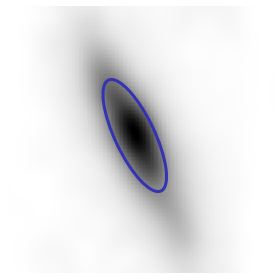

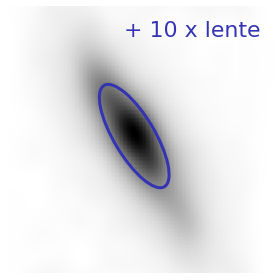

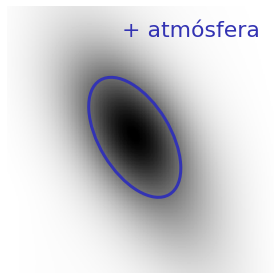

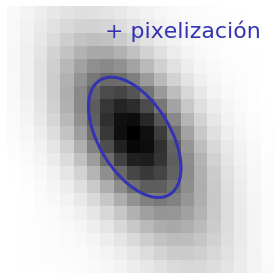

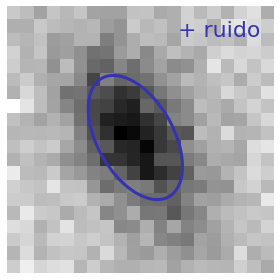

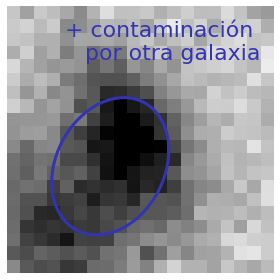

In [12]:
i=29
save_stamps(cosmos_cat, 29, "stamps_%d_spanish"%i, in_a_row=False, blend_index=14,
           add_hsm_ellipse=True, spanish=True)